In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms.functional as TF
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [181]:
# -----------------------------
# 1. Load MSNIST dataset
# -----------------------------

# This will stream the data, you don't have to download the full file
# mnist_train = load_dataset("ylecun/mnist", split="train")

# mnist_test = load_dataset("ylecun/mnist", split="test")


#### Look into the normalisation #####
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

mnist_train = datasets.MNIST("./data", train=True, download=False, transform=transforms.ToTensor())

mnist_test = datasets.MNIST("./data", train=False, download=False, transform=transforms.ToTensor())

In [182]:
def stitch_images(images, grid_size):
    """
    images: Tensor of shape (n, 1, 28, 28)
    grid_size: int, e.g., 2 or 3
    Returns: Tensor of shape (1, 28*grid_size, 28*grid_size)
    """
    assert images.shape[0] == grid_size**2
    # Remove the channel dimension for concatenation
    images = images.squeeze(1)  # Now shape: (n, 28, 28)
    rows = []
    for i in range(grid_size):
        row = torch.cat([images[i * grid_size + j] for j in range(grid_size)], dim=1)
        rows.append(row)
    stitched = torch.cat(rows, dim=0)  # Shape: (28*grid_size, 28*grid_size)
    return stitched.unsqueeze(0)       # Shape: (1, 28*grid_size, 28*grid_size)

def sample_random_images(dataset, num):
    idxs = random.sample(range(len(dataset)), num)
    imgs = []
    for i in idxs:
        img, _ = dataset[i]  # img: (1, 28, 28)
        imgs.append(img)
    return torch.stack(imgs)

(-0.5, 83.5, 83.5, -0.5)

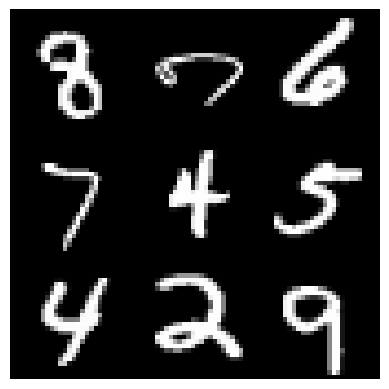

In [183]:
# Build stitched image (make sure grid_size*28 divisible by 7)
grid_size = 3
imgs = sample_random_images(mnist_train, grid_size**2)         # (4, 1, 28, 28)
stitched = stitch_images(imgs, grid_size)                      # (1, 56, 56)
plt.imshow(stitched.squeeze(), cmap='gray')
plt.axis('off')

torch.Size([1, 56, 56])


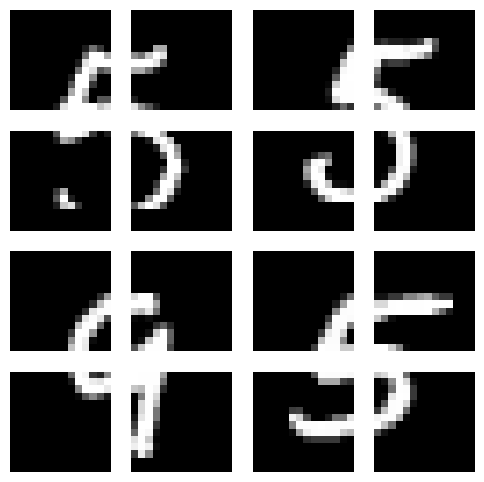

In [50]:
print(stitched.shape)  # Should be (1, 56, 56)
patches = patch(stitched, patch_size=14) 

num_patches = patches.shape[0]
side = int(num_patches ** 0.5)

fig, axes = plt.subplots(side, side, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(patches[i], cmap='gray')
    ax.axis('off')


In [184]:
class CustomMNISTDataset(torch.utils.data.Dataset):
    """ Custom Dataset for MNIST that stitches a given number of images together """
    def __init__(self, mnist_dataset, length=60000, num_images=4):
        self.mnist_dataset = mnist_dataset
        self.length = length
        self.num_images = num_images

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Get 4 random images and their labels
        images, labels = sample_random_images(self.mnist_dataset, num=self.num_images)
        stitched_image, stitched_label = stitch_and_resize(images, labels)
        return stitched_image, stitched_label

class PatchEmbed(nn.Module):
    """ Patch Embedding Layer for Vision Transformer
    Args:"""
    def __init__(self, patch_size=patch_size, embed_dim=embed_dim, img_size=img_size, in_chans=1):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = num_patches
        self.proj = nn.Linear(patch_size * patch_size * in_chans, embed_dim)

    def forward(self, x):
        # x: (B, 1, 256, 256)
        B, C, H, W = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        # patches: (B, C, num_patches_h, num_patches_w, patch_size, patch_size)
        patches = patches.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        # patches: (B, C, num_patches, patch_size, patch_size)
        patches = patches.permute(0, 2, 1, 3, 4)  # (B, num_patches, C, 16, 16)
        patches = patches.reshape(B, self.num_patches, -1)  # (B, num_patches, patch_size*patch_size*C) / (B, 256, 256)
        return self.proj(patches)  # (B, 256, embed_dim)
    
# --- Encoder Block ---
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, x):
        x_res1 = x
        x = self.ln1(x)
        x, _ = self.attn(x, x, x)
        x = x + x_res1

        x_res2 = x
        x = self.ln2(x)
        x = self.mlp(x)
        x = x + x_res2
        return x

# --- Decoder Block ---
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.masked_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln3 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, x, enc_out, mask):
        x_res1 = x
        x = self.ln1(x)
        x, _ = self.masked_attn(x, x, x, attn_mask=mask)
        x = x + x_res1

        x_res2 = x
        x, _ = self.cross_attn(x, enc_out, enc_out)

        x = self.ln2(x)
        x = x + x_res2

        x_res3 = x
        x = self.mlp(x)
        x = x + x_res3
        return x
    
# --- Visual Transformer ---
class VisualTransformer(nn.Module):
    def __init__(self, patch_size, embed_dim, num_heads, num_layers, num_classes, img_size=img_size, in_chans=1, seq_len=4):
        super().__init__()
        self.patch_embed = PatchEmbed(patch_size, embed_dim, img_size, in_chans)
        num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.pos_encod_enc = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_encod_enc, std=0.02)

        self.encoder = nn.ModuleList([EncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self.seq_len = seq_len
        self.vocab_size = num_classes + 1   # +1 for start token
        self.tok_embed = nn.Embedding(self.vocab_size, embed_dim)
        self.pos_encod_dec = nn.Parameter(torch.zeros(1, seq_len, embed_dim))
        nn.init.trunc_normal_(self.pos_encod_dec, std=0.02)

        self.decoder = nn.ModuleList([DecoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.linear = nn.Linear(embed_dim, self.vocab_size)


    def forward(self, x, y):
        # x: (B, 1, 256, 256)
        B = x.shape[0]
        x = self.patch_embed(x)                        # (B, 256, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)          # (B, 257, embed_dim)
        x = x + self.pos_encod_enc                     # (B, 257, embed_dim)
        for block in self.encoder:
            x = block(x)
        x = self.norm(x)                               # (B, 257, embed_dim)

        # y: (B, seq_len)
        y = self.tok_embed(y)                                 # (B, seq_len, embed_dim)
        curr_seq_len = y.shape[1]
        pos_encod_dec = self.pos_encod_dec[:, :curr_seq_len, :].expand(B, curr_seq_len, -1)
        y = y + pos_encod_dec                           # (B, seq_len, embed_dim)
        mask = torch.triu(torch.ones((curr_seq_len, curr_seq_len), device=x.device), diagonal=1).bool()
        for block in self.decoder:
            y = block(y, x, mask=mask)      # (B, seq_len, embed_dim)
        out = self.linear(y)                # (B, seq_len, vocab_size)
        return out

In [185]:
# Load trained model for 4 images

patch_size = 16
embed_dim = 64
num_heads = 4
num_layers = 3
num_classes = 10
img_size = 256
seq_len = 4  # Number of digits to predict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisualTransformer(
    patch_size=patch_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,
    img_size=img_size,
    seq_len=seq_len,
).to(device)

model.load_state_dict(torch.load('mnist_vit_4_enc_dec.pth', map_location=device))
model.eval()

VisualTransformer(
  (patch_embed): PatchEmbed(
    (proj): Linear(in_features=256, out_features=64, bias=True)
  )
  (encoder): ModuleList(
    (0-2): 3 x EncoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
      )
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=64, out_features=10, bias=True)
  (tok_embed): Embedding(11, 64)
  (decoder): ModuleList(
    (0-2): 3 x DecoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (masked_attn): MultiheadAttention(
        (out_proj): NonDynamica

In [186]:
def stitch_and_resize(images, labels, out_size=256):
    """
    images: Tensor of shape (4, 1, 28, 28)
    labels: Tensor of 4 integers representing the labels of the images
    Returns: Tensor of shape (1, out_size, out_size) and a tensor of labels of shape (4,)
    """
    assert images.shape[0] == 4
    # Squeeze channel for concatenation
    images = images.squeeze(1)  # (4, 28, 28)
    # Extract the label from each image and append in order of image selection
    labels = torch.tensor(labels)  # (4,)
    row1 = torch.cat([images[0], images[1]], dim=1)
    row2 = torch.cat([images[2], images[3]], dim=1)
    stitched = torch.cat([row1, row2], dim=0).unsqueeze(0)  # (1, 56, 56)
    # Now resize to (1, out_size, out_size)
    stitched_resized = TF.resize(stitched, [out_size, out_size])
    return stitched_resized, labels

def sample_random_images(dataset, num=4):
    """ Function to sample (4) random images from the dataset 
    Returns: Tensor of shape (num, 1, 56, 56) """
    idxs = random.sample(range(len(dataset)), num)
    imgs, labels = [], []
    for i in idxs:
        img, label = dataset[i]  # img: (1, 56, 56)
        imgs.append(img)
        labels.append(label)
    return torch.stack(imgs), labels

(-0.5, 255.5, 255.5, -0.5)

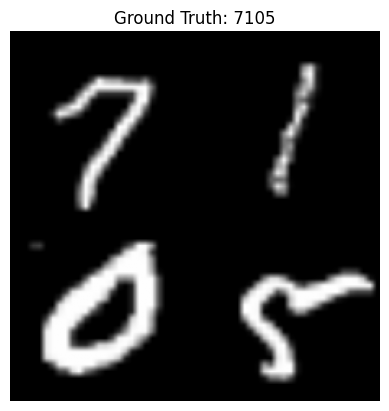

In [192]:
# Sample 4 random images and their labels
images, labels = sample_random_images(mnist_test)
stitched_img, digit_labels = stitch_and_resize(images, labels)  # shape: (1, 256, 256)

plt.imshow(stitched_img.squeeze().cpu().numpy(), cmap="gray")
plt.title("Ground Truth: " + ''.join(str(d.item()) for d in digit_labels))
plt.axis('off')

In [193]:
# Model expects (B, 1, 256, 256)
x = stitched_img.unsqueeze(0).to(device)  # Add batch dim, (1, 1, 256, 256)

# Prepare the decoder input: Start token (index 10) + <pad>
start_token = torch.full((1, 1), 10, dtype=torch.long, device=device)  # (B=1, 1)
# Initial input to decoder: only start token
y_input = start_token  # (1, 1)
outputs = []

# Autoregressive decoding loop
for t in range(seq_len):
    # Pad y_input to (1, t+1)
    logits = model(x, y_input)  # (1, t+1, vocab_size)
    next_token_logits = logits[:, -1, :]  # (1, vocab_size) -> take last step
    pred_token = next_token_logits.argmax(dim=-1)  # (1,)
    outputs.append(pred_token.item())
    y_input = torch.cat([y_input, pred_token.unsqueeze(1)], dim=1)  # (1, t+2)

pred_str = ''.join(str(d) for d in outputs)
print("Predicted digits:", pred_str)
print("Ground truth:     ", ''.join(str(d.item()) for d in digit_labels))

Predicted digits: 8808
Ground truth:      7105


In [194]:
# Assume these are already imported/defined: VisualTransformer, CustomMNISTDataset

# --- Load Model ---
model = VisualTransformer(
    patch_size=patch_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,
    img_size=img_size,
    seq_len=seq_len,
).to(device)
model.load_state_dict(torch.load('mnist_vit_4_enc_dec.pth', map_location=device))
model.eval()

# --- Prepare Test Dataset & Loader ---
test_dataset_stitch = CustomMNISTDataset(mnist_test, num_images=4, length=20000)  # or match your config
test_loader_stitch = DataLoader(test_dataset_stitch, batch_size=64, shuffle=False)

# --- Batch Evaluation ---
total_tokens, correct_tokens = 0, 0
total_seqs, correct_seqs = 0, 0

with torch.no_grad():
    for x_batch, y_batch in test_loader_stitch:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        B = x_batch.size(0)
        start_tokens = torch.full((B, 1), 10, dtype=torch.long, device=device)
        y_input = start_tokens

        # Autoregressive decoding (greedy)
        preds = []
        for t in range(seq_len):
            logits = model(x_batch, y_input)
            next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
            preds.append(next_token)
            y_input = torch.cat([y_input, next_token], dim=1)
        preds = torch.cat(preds, dim=1)  # (B, seq_len)

        # --- Token accuracy ---
        correct_tokens += (preds == y_batch).sum().item()
        total_tokens += y_batch.numel()

        # --- Sequence accuracy ---
        # Sequence is correct only if *all* tokens match for that sample
        seq_matches = (preds == y_batch).all(dim=1)   # shape (B,)
        correct_seqs += seq_matches.sum().item()
        total_seqs += B

token_acc = 100 * correct_tokens / total_tokens
seq_acc = 100 * correct_seqs / total_seqs
print(f"Token Accuracy: {token_acc:.2f}% | Sequence Accuracy: {seq_acc:.2f}%")


Token Accuracy: 44.09% | Sequence Accuracy: 3.23%


/var/folders/h3/syzlph196gggwwlj2q3qdr_40000gn/T/ipykernel_22974/1215277996.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


(-0.5, 255.5, 255.5, -0.5)

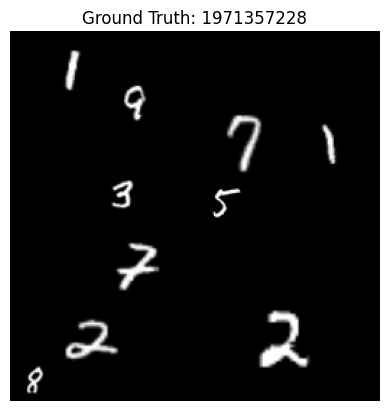

In [180]:
###### TEST #######


def stitch_and_resize(images, labels, out_size=img_size, min_scale=0.75, max_scale=2):
    images = images.squeeze(1)
    labels = torch.tensor(labels)
    N = len(images)

    canvas = torch.zeros((out_size, out_size), dtype=images.dtype, device=images.device)
    occupied_mask = torch.zeros((out_size, out_size), dtype=torch.bool, device=images.device)
    centers = []

    max_attempts = 100
    for i in range(N):
        scale = random.uniform(min_scale, max_scale)
        orig_digit_size = images[i].shape[-1]
        new_digit_size = int(orig_digit_size * scale)
        new_digit_size = max(8, min(new_digit_size, out_size))  # avoid too small or too big
        digit_resized = TF.resize(images[i].unsqueeze(0), [new_digit_size, new_digit_size]).squeeze(0)
        
        placed = False
        for _ in range(max_attempts):
            x = random.randint(0, out_size - new_digit_size)
            y = random.randint(0, out_size - new_digit_size)
            region = occupied_mask[y:y+new_digit_size, x:x+new_digit_size]
            if not region.any():
                canvas[y:y+new_digit_size, x:x+new_digit_size] = digit_resized
                occupied_mask[y:y+new_digit_size, x:x+new_digit_size] = True
                center_x = x + new_digit_size // 2
                center_y = y + new_digit_size // 2
                centers.append((center_x, center_y, labels[i].item()))
                placed = True
                break
        if not placed:
            raise RuntimeError(f"Could not place digit {i} after {max_attempts} attempts. Try fewer digits.")

    # Improved row grouping (same as before)
    centers = sorted(centers, key=lambda t: t[1])  # sort by y
    rows = []
    row = [centers[0]]
    row_height_thresh = int(28 * 0.8)  # you can set this relative to orig digit size or avg new size
    for c in centers[1:]:
        avg_y = sum([d[1] for d in row]) / len(row)
        if abs(c[1] - avg_y) <= row_height_thresh:
            row.append(c)
        else:
            rows.append(row)
            row = [c]
    if row:
        rows.append(row)

    rows = sorted(rows, key=lambda r: sum([d[1] for d in r]) / len(r))
    centers_ordered = []
    for row in rows:
        row_sorted = sorted(row, key=lambda t: t[0])
        centers_ordered.extend(row_sorted)
    sorted_labels = torch.tensor([label for _, _, label in centers_ordered], dtype=labels.dtype, device=labels.device)

    stitched = canvas.unsqueeze(0)
    return stitched, sorted_labels



N = 10
idxs = torch.randint(0, len(mnist_test), (N,))
imgs, labels = zip(*[mnist_test[i] for i in idxs])
imgs = torch.stack(imgs)  # (N, 1, 28, 28)
labels = torch.tensor(labels)

# Use your function
stitched_img, digit_labels = stitch_and_resize(imgs, labels)

plt.imshow(stitched_img.squeeze().cpu().numpy(), cmap="gray")
plt.title("Ground Truth: " + ''.join(str(d.item()) for d in digit_labels))
plt.axis('off')